# Final Project

<font color=blue> **Proposal: Develop model that predicts Origin Airport (varialbe 17) based on other vriables** </font>

A little about the dataset:
http://stat-computing.org/dataexpo/2009/the-data.html

The data comes originally from RITA where it is described in detail. You can download the data there, or from the bzipped csv files listed below. These files have derivable variables removed, are packaged in yearly chunks and have been more heavily compressed than the originals.

Variable descriptions
Name	Description
1.	Year - 	1987-2008
2. Month - 	1-12
3.	DayofMonth -	1-31
4.	DayOfWeek -	1 (Monday) - 7 (Sunday)
5.	DepTime -	actual departure time (local, hhmm)
6.	CRSDepTime -	scheduled departure time (local, hhmm)
7.	ArrTime -	actual arrival time (local, hhmm)
8.	CRSArrTime -	scheduled arrival time (local, hhmm)
9.	UniqueCarrier -	unique carrier code
10.	FlightNum -	flight number
11.	TailNum -	plane tail number
12.	ActualElapsedTime -	in minutes
13.	CRSElapsedTime -	in minutes
14.	AirTime -	in minutes
15.	ArrDelay -	arrival delay, in minutes
16.	DepDelay -	departure delay, in minutes
17.	Origin -	origin IATA airport code
18.	Dest -	destination IATA airport code
19.	Distance -	in miles
20.	TaxiIn -	taxi in time, in minutes
21.	TaxiOut -	taxi out time in minutes
22.	Cancelled -	was the flight cancelled?
23.	CancellationCode -	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	Diverted -	1 = yes, 0 = no
25.	CarrierDelay -	in minutes
26.	WeatherDelay -	in minutes
27.	NASDelay -	in minutes
28.	SecurityDelay -	in minutes
29. LateAircraftDelay -	in minutes

### SET DIRECTORIES / IMPORT LIBRARIES

In [61]:
dir_wd = 'C:\\Users\\mciniello\\Desktop\\Data Science Fundementals\\Big Data\\Final Project'
dir_datasets = 'C:\\Users\\mciniello\\Desktop\\datasets'

In [155]:
#import necessary modeules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import urllib
import bz2
from sklearn.base import BaseEstimator, TransformerMixin
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# print all variables as jupyter outputs (even if not at end of kernel)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#set display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

#for clearing outputs (useful for using 'verbose=10' then print results)
from IPython.display import clear_output

#display
import time
import re

# 1. Scrape data, unzip, delete zip files

In [63]:
root_1 = "http://stat-computing.org/dataexpo/2009/"
root_2 = ".csv.bz2"

def fetch_data(year):
    if len(os.listdir(dir_datasets))>20:
        return "Data already downloaded!"
    else:
        year = year
        URL = root_1 + str(year) + root_2
        data_name = os.path.join(dir_datasets,str(year)+root_2)

        urllib.request.urlretrieve(URL,data_name) #fetch and store data
        zipfile = bz2.BZ2File(data_name) # open the file

        data = zipfile.read() # get the decompressed data
        newfilepath = data_name[:-4] # assuming the filepath ends with .bz2
        open(newfilepath, 'wb').write(data) # write a uncompressed file

        zipfile.close() #cloze zip file
        os.remove(data_name) #delete zipfile
        print('File download complete: '+ str(year))   

for i in range(1987,2008+1):
    if fetch_data(i) == "Data already downloaded!":
        print("Data already downloaded!")
        break
    else:
        fetch_data(i)

Data already downloaded!


# 2. Import csv files into dict and stack dataframes

- NOTE: Select 5k rows from each CSV file. 
- We should probably try to do a stratifed sample, so we can keep the class imbalance. However that would require loading all of the data and taking a measure of frequency of ALL of the classes, and we simply dont have the computing power for that.
- Import the list_airports.csv file and merge it to the previous dataset so we can get information on airport names and states

In [64]:
def import_csvs(first_year, num_files, sample_size, filepath):       
    if (first_year + num_files) > 2009:
        print("TOO MANY FILES!!!")
        return None 
    else:
        data_dict={} 
        for n in range(0,num_files):
            year=first_year+n
            file = os.path.join(filepath,str(year)+'.csv')
            n = sum(1 for line in open(file)) - 1 #the '-1' excludes header in total num of rows
            s = sample_size #desired sample size
            rows_to_skip = random.sample(range(1,n+1), n-s)        
            try:
                df = pd.read_csv(file,skiprows=rows_to_skip)
            except:
                print("Oops! UTF-8 doesnt work on year " + str(year) + '... going to try Latin-1 encoding' )
                df = pd.read_csv(file,skiprows=rows_to_skip, encoding='Latin-1')
            data_dict[year] = df
            print('File import complete: '+ str(year))
        return data_dict

In [130]:
flights_smaple_path = os.path.join(dir_wd,'flights_sample.csv')

if os.path.exists(flights_smaple_path):
    print("Data already saved! Loaded as 'df'")
    df = pd.read_csv(flights_smaple_path).iloc[:,1:]
    pass
else:
    data_dict = import_csvs(1987,22,10000, filepath=dir_datasets)
    #create concatenated dataframe
    df = pd.concat(data_dict.values(), ignore_index=True)
    print(df.shape)
    #save to excel
    df.to_csv(flights_smaple_path, encoding='utf-8')
    #check to see if all file sizes and columns matche
    print("Begining data load tests:")
    rows = []
    for key in data_dict.keys():
        rows.append(data_dict[key].shape[0])
        print(data_dict[key].shape)

    total_rows = sum(rows)
    print('Final DF should have: '+ str(total_rows) + ' rows','\n')

    #check to see if all column names match
    col_names = data_dict[1987].columns
    for key in data_dict.keys():
        if (col_names == data_dict[key].columns).all():
            print(str(key)+' cols match!')
        else:
            print(str(key)+' is about to mess you day up')

Data already saved! Loaded as 'df'


C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (11,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [131]:
df.shape
df.columns

(220000, 29)

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

#### Merge data with List of Airports

In [132]:
list_airports = pd.read_csv('List_airports.csv')
list_airports.shape
list_airports.head()

(3376, 7)

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [133]:
print('Original df shape: ', df.shape)

#Add Origin State
df_merge = df.merge(list_airports, left_on="Origin",right_on="iata",)
#Add Destination state
df_merge = df_merge.merge(list_airports, left_on="Dest",right_on="iata", suffixes=('_orig','_dest'))
print('Megred df shape: ', df_merge.shape)

df_merge.head()

Original df shape:  (220000, 29)
Megred df shape:  (220000, 43)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,iata_orig,airport_orig,city_orig,state_orig,country_orig,lat_orig,long_orig,iata_dest,airport_dest,city_dest,state_dest,country_dest,lat_dest,long_dest
0,1987,10,21,3,644.0,645,808.0,804,PS,1471,NaN,84.0,79.0,NaN,4.0,-1.0,SAN,OAK,446.0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,SAN,San Diego International-Lindbergh,San Diego,CA,USA,32.733556,-117.189657,OAK,Metropolitan Oakland International,Oakland,CA,USA,37.721291,-122.220717
1,1987,10,21,3,1029.0,1029,1140.0,1144,PS,1475,NaN,71.0,75.0,NaN,-4.0,0.0,SAN,OAK,446.0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,SAN,San Diego International-Lindbergh,San Diego,CA,USA,32.733556,-117.189657,OAK,Metropolitan Oakland International,Oakland,CA,USA,37.721291,-122.220717
2,1987,10,7,3,1951.0,1951,2129.0,2118,AA,2359,NaN,98.0,87.0,NaN,11.0,0.0,SAN,OAK,446.0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,SAN,San Diego International-Lindbergh,San Diego,CA,USA,32.733556,-117.189657,OAK,Metropolitan Oakland International,Oakland,CA,USA,37.721291,-122.220717
3,1987,11,13,5,634.0,635,800.0,758,PS,1471,NaN,86.0,83.0,NaN,2.0,-1.0,SAN,OAK,446.0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,SAN,San Diego International-Lindbergh,San Diego,CA,USA,32.733556,-117.189657,OAK,Metropolitan Oakland International,Oakland,CA,USA,37.721291,-122.220717
4,1987,12,23,3,1042.0,1040,1214.0,1201,PS,1475,NaN,92.0,81.0,NaN,13.0,2.0,SAN,OAK,446.0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,SAN,San Diego International-Lindbergh,San Diego,CA,USA,32.733556,-117.189657,OAK,Metropolitan Oakland International,Oakland,CA,USA,37.721291,-122.220717


# 3. Explore data

In [69]:
df_merge.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,lat_orig,long_orig,lat_dest,long_dest
count,220000.000000,220000.000000,220000.000000,220000.000000,215964.000000,220000.000000,215448.000000,220000.000000,220000.000000,215441.000000,219948.000000,136676.000000,215441.000000,215964.000000,219596.000000,139798.000000,139822.000000,220000.000000,220000.000000,48133.000000,48133.000000,48133.000000,48133.000000,48133.000000,220000.000000,220000.000000,220000.000000,220000.000000
mean,1997.500000,6.715941,15.721959,3.931764,1350.307639,1335.971695,1494.705479,1490.626695,1272.672477,118.910565,119.692532,102.816903,7.035393,7.985674,695.203874,6.345048,15.136166,0.018345,0.002377,3.535662,0.799348,4.105167,0.027382,4.792782,37.086268,-93.855364,37.092247,-93.875347
std,6.344303,3.483515,8.798874,1.993970,476.688748,476.674507,497.996470,494.011953,1307.040174,68.206275,67.758832,70.266305,29.961508,27.033153,548.296794,20.034718,10.756121,0.134198,0.048699,19.690704,9.703803,16.762670,1.275858,20.624679,5.589727,17.147586,5.583612,17.097967
min,1987.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,14.000000,-32.000000,-1440.000000,-835.000000,-70.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.367222,-176.646031,7.367222,-176.646031
25%,1992.000000,4.000000,8.000000,2.000000,935.000000,930.000000,1117.000000,1115.000000,436.000000,69.000000,70.000000,54.000000,-7.000000,-2.000000,304.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.562943,-104.700250,33.562943,-104.667002
50%,1997.500000,7.000000,16.000000,4.000000,1335.000000,1330.000000,1523.000000,1521.000000,885.000000,100.000000,101.000000,84.000000,0.000000,0.000000,533.000000,5.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.619002,-87.904464,37.649959,-87.904464
75%,2003.000000,10.000000,23.000000,6.000000,1738.000000,1730.000000,1918.000000,1913.000000,1631.000000,150.000000,151.000000,133.000000,11.000000,6.000000,931.000000,7.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.788388,-80.943126,40.777243,-80.943126
max,2008.000000,12.000000,31.000000,7.000000,2628.000000,2359.000000,2706.000000,2400.000000,9580.000000,662.000000,660.000000,1139.000000,1182.000000,1435.000000,4962.000000,1450.000000,302.000000,1.000000,1.000000,1182.000000,751.000000,914.000000,206.000000,1016.000000,71.285448,145.621384,71.285448,145.621384


C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


(array([  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   8.00000000e+00,
          1.10000000e+01,   7.00000000e+00,   1.60000000e+01,
          3.00000000e+01,   5.10000000e+01,   5.60000000e+01,
          3.70000000e+01,   1.16000000e+02,   1.72000000e+02,
          2.30000000e+02,   2.86000000e+02,   2.40000000e+02,
          5.93000000e+02,   7.88000000e+02,   1.16200000e+03,
          1.65900000e+03,   9.71000000e+02,   2.68500000e+03,
          3.80000000e+03,   5.24600000e+03,   6.62900000e+03,
          4.02300000e+03,   1.00520000e+04,   1.14390000e+04,
          1.31420000e+04,   1.57130000e+04,   7.63100000e+03,
          1.44320000e+04,   1.54850000e+04,   1.22020000e+04,
        

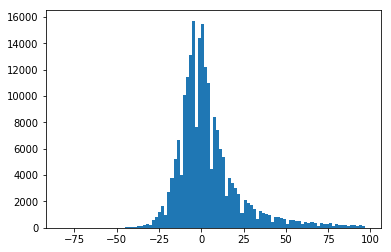

In [70]:
#show only data within 3 standard deviations of the mean
plt.hist(x=df_merge['ArrDelay'],range=(7-(30*3),7+(30*3)), bins=100)
plt.show()

In [71]:
df_merge.shape
df_merge.info()

(220000, 43)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220000 entries, 0 to 219999
Data columns (total 43 columns):
Year                 220000 non-null int64
Month                220000 non-null int64
DayofMonth           220000 non-null int64
DayOfWeek            220000 non-null int64
DepTime              215964 non-null float64
CRSDepTime           220000 non-null int64
ArrTime              215448 non-null float64
CRSArrTime           220000 non-null int64
UniqueCarrier        220000 non-null object
FlightNum            220000 non-null int64
TailNum              139780 non-null object
ActualElapsedTime    215441 non-null float64
CRSElapsedTime       219948 non-null float64
AirTime              136676 non-null float64
ArrDelay             215441 non-null float64
DepDelay             215964 non-null float64
Origin               220000 non-null object
Dest                 220000 non-null object
Distance             219596 non-null float64
TaxiIn               139798 non-null float64
TaxiOut

# 4. Feature selection and extraction

### Categorical Variables

In [134]:
#model1_feats = list(set(cols_notnull).intersection(cols_numeric))
cols_cat = df_merge.columns[df_merge.dtypes == 'object'].tolist()
cols_cat

['UniqueCarrier',
 'TailNum',
 'Origin',
 'Dest',
 'CancellationCode',
 'iata_orig',
 'airport_orig',
 'city_orig',
 'state_orig',
 'country_orig',
 'iata_dest',
 'airport_dest',
 'city_dest',
 'state_dest',
 'country_dest']

Ok, we can get rid of a few here:
- remove variables that dont add informaiton (TailNum)
- remove variables that duplicate info:
    - remove city_org, city_dest, airport_org, airport_dest
    - also remove original Orgign and Dest columns, as we will use the lat long values

In [135]:
cols_cat_remove = ['iata_orig',
                   'city_orig',
                   'TailNum',
                   'Origin',
                   'Dest',
                   'country_dest',
                   'airport_dest',
                   'iata_dest',
                   'airport_orig',
                   'CancellationCode',
                   'country_orig',
                   'city_dest']
cols_cat_final = list(set(cols_cat).difference(cols_cat_remove))
cols_cat_final

['state_orig', 'UniqueCarrier', 'state_dest']

In [136]:
df_merge[cols_cat_final].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220000 entries, 0 to 219999
Data columns (total 3 columns):
state_orig       219933 non-null object
UniqueCarrier    220000 non-null object
state_dest       219940 non-null object
dtypes: object(3)
memory usage: 6.7+ MB


In [137]:
df_merge['CRSArrTime'].apply(str_to_hrs)

0          8.066667
1         11.733333
2         21.300000
3          7.966667
4         12.016667
5         12.416667
6         14.583333
7         22.666667
8         22.733333
9         14.933333
10        22.350000
11         7.900000
12        20.350000
13        18.750000
14        22.283333
15        13.833333
16         8.833333
17         9.000000
18        16.750000
19        10.500000
20        16.500000
21        22.850000
22        16.666667
23        19.233333
24        21.166667
25        10.416667
26        16.666667
27        12.416667
28        22.250000
29        14.750000
            ...    
219970    19.166667
219971     9.433333
219972    10.500000
219973    20.416667
219974    10.200000
219975    13.583333
219976     6.666667
219977     7.166667
219978     7.166667
219979    16.833333
219980     6.666667
219981     9.083333
219982     7.166667
219983     9.166667
219984     6.500000
219985     7.166667
219986     7.250000
219987    19.250000
219988     7.666667


### Numerical Variables

- delete all features that leak information (ie, are recoreded after flight has landed)
- remove date variables (which need to be converted to numerical features)

In [138]:
#model1_feats = list(set(cols_notnull).intersection(cols_numeric))
cols_num = df_merge.columns[df_merge.dtypes != 'object'].tolist()
df_merge[cols_num].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220000 entries, 0 to 219999
Data columns (total 28 columns):
Year                 220000 non-null int64
Month                220000 non-null int64
DayofMonth           220000 non-null int64
DayOfWeek            220000 non-null int64
DepTime              215964 non-null float64
CRSDepTime           220000 non-null int64
ArrTime              215448 non-null float64
CRSArrTime           220000 non-null int64
FlightNum            220000 non-null int64
ActualElapsedTime    215441 non-null float64
CRSElapsedTime       219948 non-null float64
AirTime              136676 non-null float64
ArrDelay             215441 non-null float64
DepDelay             215964 non-null float64
Distance             219596 non-null float64
TaxiIn               139798 non-null float64
TaxiOut              139822 non-null float64
Cancelled            220000 non-null int64
Diverted             220000 non-null int64
CarrierDelay         48133 non-null float64
WeatherD

In [139]:
cols_num_remove=['DepTime',
 'ArrTime',
 'FlightNum',
'CRSDepTime',
'CRSArrTime',             
 'ActualElapsedTime',
 'AirTime',
 'DepDelay',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']
cols_num_final = list(set(cols_num).difference(cols_num_remove))

df_merge[cols_num_final].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220000 entries, 0 to 219999
Data columns (total 11 columns):
long_orig         220000 non-null float64
lat_orig          220000 non-null float64
long_dest         220000 non-null float64
Year              220000 non-null int64
Month             220000 non-null int64
DayOfWeek         220000 non-null int64
CRSElapsedTime    219948 non-null float64
Distance          219596 non-null float64
DayofMonth        220000 non-null int64
ArrDelay          215441 non-null float64
lat_dest          220000 non-null float64
dtypes: float64(7), int64(4)
memory usage: 30.1 MB


### Date Variables

In [140]:
cols_date_final = ['CRSArrTime','CRSDepTime']
df_merge[cols_date_final].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220000 entries, 0 to 219999
Data columns (total 2 columns):
CRSArrTime    220000 non-null int64
CRSDepTime    220000 non-null int64
dtypes: int64(2)
memory usage: 15.0 MB


# 5. Build Cleansing Pipeline

1. Delete rows with cancelld or diverted flights
2. Select data frame/delete nulls based on cols_cat_final + cols_num_final + cols_dates_final
3. Add dep/arr state match column
4. Categorical transormation, drop original columns
5. Dates transormation, drop original columns
6. Convert to matrix (Make target col the last column)

In [141]:
df_merge.shape

(220000, 43)

#### A. Delete rows with cancelled or diverted flights

In [80]:
#create transformer to delete rows
class Delete_Cancelled_Diverted(BaseEstimator, TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_clean = X[(X.Cancelled == 0) & (X.Diverted == 0)]
        return X_clean

pl_1 = Delete_Cancelled_Diverted()
df_trans_1 = pl_1.transform(df_merge)
df_trans_1.shape

(215441, 43)

#### B. Select Features (including target) and remove nulls

In [81]:
# Create transformer to select subset of data
class Select_Remove_Nulls(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_clean = X.loc[:,self.attribute_names]
        X_clean = X_clean.dropna()
        return X_clean  

#test transformer
rows = df_trans_1.shape[0]
features_final = cols_cat_final + cols_num_final + cols_date_final

pl_2 = Select_Remove_Nulls(attribute_names=features_final)
df_trans_2 = pl_2.transform(df_trans_1)
df_trans_2.shape

(214923, 16)

#### C. Intra/Inter state feature

In [82]:
#create transformer to delete rows
class IntraStateComp(BaseEstimator, TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['intra_state_comp'] = (X['state_orig'] == X['state_dest'])*1
        return X

pl_3 = IntraStateComp()
df_trans_3 = pl_3.transform(df_trans_2)
df_trans_3.shape

(214923, 17)

In [ ]:

  X['intra_state'] = (X['orig'] == X['dest'])*1


#### D. Categorical Transformation

In [83]:
# Create transformer to select subset of data
class CategoricalTrans(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for col in self.attribute_names:
            X = pd.concat([X, pd.get_dummies(X[col],prefix=col)],axis=1)
        X = X.drop(self.attribute_names,axis=1)
        return X  
    
final_pipeline = Pipeline([
('CatEncoder', CategoricalTrans(cols_cat_final)),
('df_tomatrix',Xy_to_matrix(target))
]) 

pl_4 = CategoricalTrans(attribute_names=cols_cat_final)
df_trans_4 = pl_4.transform(df_trans_3)
df_trans_4.shape

(214923, 149)

#### E. Dates Transformation

In [84]:
# Create transformer to convert departure and arrival times to hours
def str_to_hrs(x):
    x=str(int(x))
    if x == '2400':
        x = '2359'
    if len(x)<3:
        x_dt = datetime.strptime(str(x),'%M')
    else:
        x_dt = datetime.strptime(str(x),'%H%M')
    return x_dt.hour + (x_dt.minute/60)

class FloatHourAdder(BaseEstimator, TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self # nothing to do here!
    def transform(self, X, y=None): #no y required as we are just cleaning features
        for col in self.attribute_names:
            X['%s_HOUR_CLEAN'%(col)] = X[col].apply(str_to_hrs)
        X=X.drop(self.attribute_names, axis=1) #drop original columns
        return X
    
pl_5 = FloatHourAdder(cols_date_final)
df_trans_5 = pl_5.transform(df_trans_4)
df_trans_5.shape

(214923, 149)

#### F. to_matrix Transformation

In [85]:
# Create transformer to select subset of data
class Xy_to_matrix(BaseEstimator, TransformerMixin):
    def __init__(self, target):
        self.target = target
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        y = X[target].as_matrix()
        X = X.drop(target,axis=1).as_matrix()
        return X, y  

#test transformer
target =  'ArrDelay'

pl_6 = Xy_to_matrix(target)
df_X, df_y = pl_6.transform(df_trans_5)
df_X.shape
df_y.shape

(214923, 148)

(214923,)

# 6. Run Pipeline / Model Prep

#### 1. Cleansing Pipeline (both train and test)
- a. Delete rows with cancelld or diverted flights
- b. Select data frame/delete nulls based on cols_cat_final + cols_num_final + cols_dates_final
- c. Add dep/arr state match column
- d. Categorical transormation, drop original columns
- e. Dates transormation, drop original columns
- f. Convert to matrix (Make target col the last column)

#### 2. Split/shuflle into test train
- a. Create df_train, df_test (both include X AND y)

#### 3. Run models: 10 models for both Linear Regression, RandomForestRegression
- Test size 10% to 100% of training data. 
- Test accuracy on each model
- Record training times and accuracies

#### 1. Cleansing Pipeline (both train and test)

In [142]:
print('Pre-cleanse features:','\n')
print('Categorical cols: ', cols_cat_final)
print('Date cols: ', cols_date_final)
print('Numerical cols (including target): ', cols_num_final)
features_final = cols_cat_final + cols_num_final + cols_date_final
print('Total number of features: ', len(features_final))      

Pre-cleanse features: 

Categorical cols:  ['state_orig', 'UniqueCarrier', 'state_dest']
Date cols:  ['CRSArrTime', 'CRSDepTime']
Numerical cols (including target):  ['long_orig', 'lat_orig', 'long_dest', 'Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 'DayofMonth', 'ArrDelay', 'lat_dest']
Total number of features:  16


In [87]:
features_final

['state_orig',
 'UniqueCarrier',
 'state_dest',
 'long_orig',
 'lat_orig',
 'long_dest',
 'Year',
 'Month',
 'DayOfWeek',
 'CRSElapsedTime',
 'Distance',
 'DayofMonth',
 'ArrDelay',
 'lat_dest',
 'CRSArrTime',
 'CRSDepTime']

In [145]:
final_pipeline = Pipeline([
    ('canc_divt',Delete_Cancelled_Diverted()),
    ('FeatSelect',Select_Remove_Nulls(features_final)),
    ('dep_arr_match', IntraStateComp()),
    ('CatEncoder', CategoricalTrans(cols_cat_final)),
    ('DatesFix', FloatHourAdder(cols_date_final)),
    ('df_tomatrix',Xy_to_matrix(target))
    ])    

In [146]:
X_clean, y_clean = final_pipeline.fit_transform(df_merge)

#### 2. Split/shuflle into test train

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, 
                                                    y_clean, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True)

print('X_train shape: ' ,X_train.shape)
print('X_test shape: ' ,X_test.shape)
print('y_train shape: ' ,y_train.shape)
print('y_test shape: ' ,y_test.shape)

X_train shape:  (171938, 148)
X_test shape:  (42985, 148)
y_train shape:  (171938,)
y_test shape:  (42985,)


In [90]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

X_train_df.shape
X_test_df.shape
y_train_df.shape
y_test_df.shape

(171938, 149)

(42985, 149)

(171938, 1)

(42985, 1)

#move to csvs on disk
os.getcwd()
X_train_df.to_csv('X_train')
X_test_df.to_csv('X_test')
y_train_df.to_csv('y_train')
y_test_df.to_csv('y_test')

#### 3. Run models: 10 models for both Linear Regression, RandomForestRegression

In [158]:
def run_model(X_train, X_test, y_train, y_test, model, num_models=10, left_axis=[30,31], right_axis=[0,10]):
    #get sample sizes
    n_rows_samp = X_train.shape[0]/num_models 
    samp_size = []

    for i in range(1,num_models+1):
        samp_size.append(int(n_rows_samp * i))
    #get rmses and runtimes
    rmses = []
    runtimes = []
    for k, n in enumerate(samp_size):
        t1 = time.time()
        model.fit(X_train[0:n], y_train[0:n])
        preds = model.predict(X_test)
        t2 = time.time()
        rmse = np.sqrt(mean_squared_error(y_test,preds))
        rmses.append(rmse)
        runtime = t2-t1
        runtimes.append(runtime)
        print('Model run ' + str(k) + ' complete: runtime = ' + str(runtime) + ', rmse = ' + str(rmse))
    #plot rmses
    fig, ax1 = plt.subplots()
    ax1.plot(samp_size, rmses, 'b-')
    ax1.set_xlabel('Sample Size (rows)')
    ax1.set_ylabel('RMSE (Minutes Delayed)', color='b')
    
    ax1.tick_params('y', colors='b')
    #plot runtimes
    ax2 = ax1.twinx()
    ax2.plot(samp_size, runtimes, 'r-')
    ax2.set_ylabel('Runtime (seconds)', color='r')
    
    ax2.tick_params('y', colors='r')
    plt.title(re.findall('[A-Z]+[a-z]+[A-Z]+[a-z]+',str(model))[0],fontsize=20)
    fig.tight_layout()
    ax1.set_ylim(left_axis)
    ax2.set_ylim(right_axis)
    plt.show()
    print('Average RMSE: ', np.average(rmses))
    print('Average Runtime: ', np.average(runtimes))
    return rmses, runtimes, samp_size

Model run 0 complete: runtime = 0.1640000343322754, rmse = 30.3506646626
Model run 1 complete: runtime = 0.4030001163482666, rmse = 30.2659982046
Model run 2 complete: runtime = 0.6340000629425049, rmse = 30.2458773403
Model run 3 complete: runtime = 0.8420000076293945, rmse = 30.2470528756
Model run 4 complete: runtime = 0.9699997901916504, rmse = 30.2368939738
Model run 5 complete: runtime = 1.2710001468658447, rmse = 30.2367779797
Model run 6 complete: runtime = 1.2869999408721924, rmse = 30.2323815348
Model run 7 complete: runtime = 1.4920001029968262, rmse = 30.2259720632
Model run 8 complete: runtime = 1.6559998989105225, rmse = 30.2228111175
Model run 9 complete: runtime = 1.9510002136230469, rmse = 30.2205852155


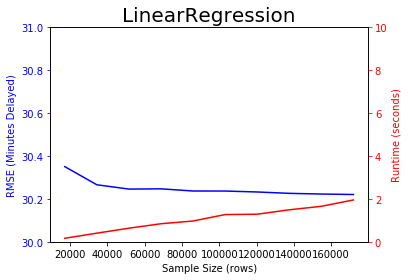

Average RMSE:  30.2485014968
Average Runtime:  1.06700003147


In [159]:
# Linear Model
lr_rmses, lr_runtimes, samp_size = run_model(X_train, X_test, y_train, y_test, 
                                             LinearRegression())

Model run 0 complete: runtime = 2.7972798347473145, rmse = 30.2961296183
Model run 1 complete: runtime = 5.076507568359375, rmse = 30.2832825618
Model run 2 complete: runtime = 8.578857660293579, rmse = 30.2820964221
Model run 3 complete: runtime = 11.634163618087769, rmse = 30.2828554082
Model run 4 complete: runtime = 13.977397680282593, rmse = 30.2824567777
Model run 5 complete: runtime = 16.475647449493408, rmse = 30.2797802899
Model run 6 complete: runtime = 19.851985216140747, rmse = 30.2795156017
Model run 7 complete: runtime = 23.82038164138794, rmse = 30.2794043633
Model run 8 complete: runtime = 28.429842710494995, rmse = 30.2791344901
Model run 9 complete: runtime = 33.486348390579224, rmse = 30.2796865649


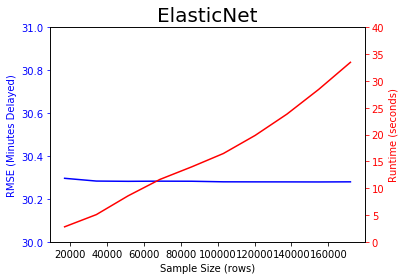

Average RMSE:  30.2824342098
Average Runtime:  16.412841177


In [153]:
# ElasticNet Model
en_rmses, en_runtimes, samp_size = run_model(X_train, X_test, y_train, y_test, 
                                             ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42), 
                                             right_axis=[0,40])

Model run 0 complete: runtime = 18.189818620681763, rmse = 30.8942791407
Model run 1 complete: runtime = 43.66036558151245, rmse = 30.4204800531
Model run 2 complete: runtime = 74.26242542266846, rmse = 30.2298206069
Model run 3 complete: runtime = 109.43194222450256, rmse = 30.2909779001
Model run 4 complete: runtime = 134.66646528244019, rmse = 30.2044455515
Model run 5 complete: runtime = 173.68336653709412, rmse = 30.2989660492
Model run 6 complete: runtime = 197.85469269752502, rmse = 30.1908331235
Model run 7 complete: runtime = 241.726824760437, rmse = 30.1019693968
Model run 8 complete: runtime = 283.2382230758667, rmse = 30.1026348626
Model run 9 complete: runtime = 309.7449998855591, rmse = 30.0652037924


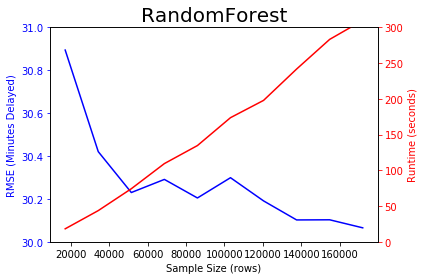

Average RMSE:  30.2799610477
Average Runtime:  158.645912409


In [156]:
# RandomForest Model
rf_rmses, rf_runtimes, samp_size = run_model(X_train, X_test, y_train, y_test, 
                                             RandomForestRegressor(n_estimators=100, max_depth=10),
                                             left_axis=[30,31],
                                             right_axis=[0,300])